In [81]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import datetime
from scipy.stats import linregress
from pandas_datareader import data as pdr
import yfinance as yf
import multiprocessing as mp
import time 
from tqdm import tqdm

In [82]:
yf.pdr_override()

In [141]:
df = pd.read_csv("./bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")
print(df.columns)
df.head()


Index(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume_(BTC)',
       'Volume_(Currency)', 'Weighted_Price'],
      dtype='object')


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [164]:
print(df[df['Close'].isna()].tail())

                      Timestamp  Open  High  Low  Close  Volume_(BTC)  \
date                                                                    
2021-03-29 22:09:00  1617080940   NaN   NaN  NaN    NaN           NaN   
2021-03-29 23:12:00  1617084720   NaN   NaN  NaN    NaN           NaN   
2021-03-30 00:20:00  1617088800   NaN   NaN  NaN    NaN           NaN   
2021-03-30 16:24:00  1617146640   NaN   NaN  NaN    NaN           NaN   
2021-03-30 16:52:00  1617148320   NaN   NaN  NaN    NaN           NaN   

                     Volume_(Currency)  Weighted_Price  
date                                                    
2021-03-29 22:09:00                NaN             NaN  
2021-03-29 23:12:00                NaN             NaN  
2021-03-30 00:20:00                NaN             NaN  
2021-03-30 16:24:00                NaN             NaN  
2021-03-30 16:52:00                NaN             NaN  


In [142]:
datetime_str = '1325318160'
datetime.fromtimestamp(1325318160)
# datetime_object = datetime.strptime(datetime_str, '%m/%d/%Y %H:%M')
datetime_converted = pd.Series([datetime.fromtimestamp(el) for el in df['Timestamp']])
df['date'] = datetime_converted
df.set_index('date', inplace=True)
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
date,,,,,,,,
2011-12-30 23:52:00,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2011-12-30 23:53:00,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-30 23:54:00,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-30 23:55:00,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-30 23:56:00,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [160]:
rng = df.loc['2015-1-10 19:46:00':'2015-1-11 7:46:00']
rng.head()


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
date,,,,,,,,
2015-01-10 19:46:00,1420947960,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-10 19:47:00,1420948020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-10 19:48:00,1420948080,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-10 19:49:00,1420948140,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-10 19:50:00,1420948200,279.83,280.09,279.83,280.09,0.5051,141.398319,279.941237


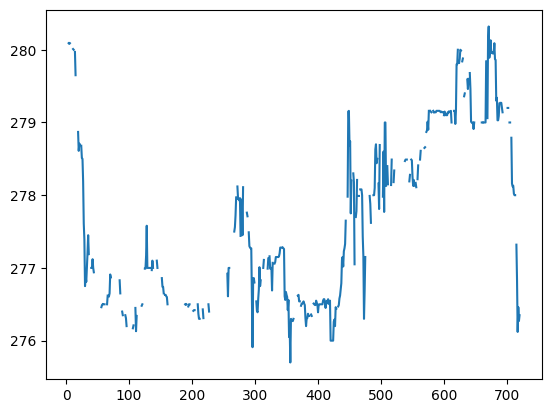

In [158]:
rng = df.loc['2015-1-10 19:46:00':'2015-1-11 7:46:00']
plt.plot(np.arange(len(rng)), rng['Close'])

In [131]:
# datetime_converted = pd.Series([datetime.strptime(el, '%m/%d/%Y %H:%M') for el in df['date']])
# df['date'] = datetime_converted
# df.set_index('date', inplace=True)
# df.tail()

# Some Functions

In [146]:
def getTEvents(raw_price, h):
    """
    Finds timestamps of 'events' i.e. spots where something interesting happens
    according to the symmetric CUSUM filter.
    """
    tEvents, sPos, sNeg = [], 0, 0
    diff = np.log(raw_price).diff().dropna()
    for i in tqdm(diff.index[1:]):
        sPos, sNeg = max(0, sPos + diff.loc[i]), min(0, sNeg + diff.loc[i])
        if sNeg < -h:
            sNeg = 0
            tEvents.append(i)
        elif sPos > h:
            sPos = 0
            tEvents.append(i)
    return pd.DatetimeIndex(tEvents)

In [144]:
def get_daily_vol(closing_prices, lookback=100):
    """
    Returns:
        A pd.Series of daily volatility value
    """
    print('Calculating daily volatility for dynamic thresholds')
    
    df_ = closing_prices.index.searchsorted(closing_prices.index - pd.Timedelta(days=1))
    df_ = df_[df_ > 0]
    df_ = (pd.Series(closing_prices.index[df_ - 1], index=closing_prices.index[closing_prices.shape[0] - df_.shape[0]:]))
        
    df_ = closing_prices.loc[df_.index] / closing_prices.loc[df_.values].values - 1  # daily returns
    df_ = df_.ewm(span=lookback).std()
    return df_

In [134]:
def applyPtSlOnT1(close, events, ptSl, molecule):
    # apply stop loss/profit taking, if it takes place before t1 (end of event)
    events_ = events.loc[molecule]
    out = events_[['t1']].copy(deep=True)
    if ptSl[0] > 0:
        pt = ptSl[0] * events_['target']
    else:
        pt = pd.Series(index=events.index) # NaNs
    if ptSl[1] > 0:
        sl=-ptSl[1] * events_['target']
    else:
        sl = pd.Series(index=events.index) # NaNs
    for loc, t1 in events_['t1'].fillna(close.index[-1]).iteritems():
        df0 = close[loc:t1] # path prices
        df0 = (df0 / close[loc]-1) * events_.at[loc, 'side'] # path returns
        out.loc[loc,'sl'] = df0[df0<sl[loc]].index.min() # earliest stop loss.
        out.loc[loc,'pt'] = df0[df0>pt[loc]].index.min() # earliest profit taking.
    return out

In [135]:
def getBins(events, close):
    """
    Compute event's outcome (including side information, if provided).
    events is a DataFrame where:
    —events.index is event's starttime
    —events['t1'] is event's endtime
    —events['trgt'] is event's target
    —events['side'] (optional) implies the algo's position side
    Case 1: ('side' not in events): bin in (-1,1) <—label by price action
    Case 2: ('side' in events): bin in (0,1) <— label by pnl (meta-labeling)
    """
    #1) prices aligned with events
    events_ = events.dropna(subset=['t1'])
    px = events_.index.union(events_['t1'].values).drop_duplicates()
    px = close.reindex(px, method='bfill')
    #2) create out object
    out = pd.DataFrame(index=events_.index)
    out['ret'] = px.loc[events_['t1'].values].values / px.loc[events_.index] - 1
    if 'side' in events_:
        out['ret'] *= events_['side'] # meta-labeling
    out['bin'] = np.sign(out['ret'])
    if 'side' in events_:
        out.loc[out['ret'] <= 0, 'bin'] = 0 # meta-labeling
    return out

In [136]:
def drop_labels(events, minPtc=.05):
    """
    Apply weights, drop labels that happen too rarely
    """
    while True:
        df_ = events['bin'].value_counts(normalize=True)
        if df_.min() > minPct or df_.shape[0] < 3:
            break
        print('dropped label', df_.argmin(), df_.min())
        events = events[events['bin'] != df_.argmin()]
    return events

In [137]:
def get_events(close, tEvents, ptSl, target, min_return, num_threads, t1=False, side=None):
    target = target.loc[tEvents]
    target = target[target > min_return]
    if not t1:
        t1 = pd.Series(pd.NaT, index=tEvents) # Not a Time
    side_, ptSl_ = pd.Series(1., index=target.index), [ptSl[0], ptSl[0]] if not side else\
        side.loc[target.index], ptSl[:2]
    events = pd.concat({ "t1": t1, "target": target, "side": side_ }, axis=1).dropna(subset=["target"])
    df0 = mp_pandas_job(func=applyPtSlOnT1, pd_obj=('molecule', events.index), num_threads=num_threads,\
                        close=close, events=events, ptSl=ptSl_)
    events['t1'] = df0.dropna(how='all').min(axis=1) # pd.min ignores nan
    if side is None:
        events = events.drop('side', axis=1)
    return events

In [138]:
def bbands(close_prices, window, no_of_stdev):
    # rolling_mean = close_prices.rolling(window=window).mean()
    # rolling_std = close_prices.rolling(window=window).std()
    rolling_mean = close_prices.ewm(span=window).mean()
    rolling_std = close_prices.ewm(span=window).std()

    upper_band = rolling_mean + (rolling_std * no_of_stdev)
    lower_band = rolling_mean - (rolling_std * no_of_stdev)

    return rolling_mean, upper_band, lower_band

In [139]:
def add_vertical_barrier(t_events, close, num_days=1):
    """
    :param t_events: (series) series of events (symmetric CUSUM filter)
    :param close: (series) close prices
    :param num_days: (int) maximum number of days a trade can be active
    :return: (series) timestamps of vertical barriers
    """
    t1 = close.index.searchsorted(t_events + pd.Timedelta(days=num_days))
    t1 = t1[t1 < close.shape[0]]
    t1 = pd.Series(close.index[t1], index=t_events[:t1.shape[0]])  # NaNs at end
    return t1

In [148]:
#### Driver code
close = df['Close']
# find daily volatilities
volatilities = get_daily_vol(close)

# find timestamps where 'significant' events occurred
tEvents = getTEvents(close, volatilities.mean() * 0.1)

# adding vertical barriers with a half day expiration window
vertical_barriers = add_vertical_barrier(t_events=cusum_events,
                                         close=close, num_days=0.5)
target = volatilities
num_threads = 4
t1 = None
side = None
pt_sl = [1, 2] # setting profit-take and stop-loss at 1% and 2%
min_return = 0.0005 # setting a minimum return of 0.05%

Calculating daily volatility for dynamic thresholds


ValueError: operands could not be broadcast together with shapes (4857016,) (4856476,) 

In [123]:
window = 50
df['avg'], df['upper'], df['lower'] = bbands(df['Close'],window, no_of_stdev=1.5)

# compute sides
df['side'] = np.nan
long_signals = (df['Close'] <= df['lower'])
short_signals = (df['Close'] >= df['upper'])
df.loc[long_signals, 'side'] = 1
df.loc[short_signals, 'side'] = -1

print(df.side.value_counts())

# Remove Look ahead biase by lagging the signal
df['side'] = df['side'].shift(1)

# Drop the NaN values from our data set
df.dropna(axis=0, how='any', inplace=True)

side
 1.0    190135
-1.0    167896
Name: count, dtype: int64


In [127]:
get_events(df['Close'], tEvents, pt_sl, target, min_return, num_threads, t1=False, side=None)

ValueError: too many values to unpack (expected 2)

In [10]:
%%timeit
import multiprocessing as mp
from job import job

if __name__ == '__main__':
    # Path dependency: Multi-threaded implementation
    r, numThreads = np.random.normal(0, .01, size=(1000,10000)), 4
    parts=np.linspace(0,r.shape[0],min(numThreads,r.shape[0])+1)
    parts,jobs=np.ceil(parts).astype(int),[]
    for i in range(1,len(parts)):
        jobs.append(r[:,parts[i-1]:parts[i]]) # parallel jobs

    with mp.Pool(processes=numThreads) as pool:
        out = []
        outputs=pool.imap_unordered(job, jobs)

        for out_ in outputs:
            out.append(out_) # asynchronous response


520 ms ± 28.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
